# Spam Email Classifier

In [1]:
!pip install nltk 
!pip install pandas
!pip install numpy
!pip install matplotlib


#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Data reading

In [4]:
data = pd.read_csv('Train/emails.csv')
data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


#### Data Cleansing

In [5]:
data.drop_duplicates(inplace=True)

In [6]:
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [7]:
# Fill missing 'subject' with the mode of the 'subject' column
data['subject'].fillna(data['subject'].mode().values[0], inplace=True)

# Assuming 'message' should not be empty, we'll fill missing messages with a placeholder text
data['message'].fillna('no content', inplace=True)


In [8]:
data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [9]:
print(data.size)

8628


In [10]:
data['message'] = data['message'].str.lower()
data['subject'] = data['subject'].str.lower()

In [11]:
data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


#### Preprocessing Email Messages

In [12]:
# Create a new column 'content' by concatenating the lowercase versions of 'subject' and 'message' columns
data['content'] = data['subject'].str.lower() + ' ' + data['message'].str.lower()

In [13]:
data['content'][0]

"job posting - apple-iss research center content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical l

In [14]:
# Updated regex to handle in-text replacements more effectively
data['content'] = data['content'].str.replace(r'\\b[\\w.-]+@[\\w.-]+\\.\\w{2,4}\\b', 'emailaddress', regex=True)
data['content'] = data['content'].str.replace(r'\\bhttps?://\\S+\\b', 'webaddress', regex=True)
data['content'] = data['content'].str.replace(r'\\b\\d+\\.\\d+\\b', 'number', regex=True)
data['content'] = data['content'].str.replace(r'\\b\\$\\d+\\.\\d+\\b', 'currency', regex=True)

In [15]:
# Delete all the characters that are not white spaces or letters
data['content'] = data['content'].str.replace('[^a-zA-Z\s]', '', regex=True)
# Delete the additional white spaces
data['content'] = data['content'].str.replace('\s+', ' ', regex=True)

In [16]:
data['content'][0]

'job posting appleiss research center content length appleiss research center a us million joint venture between apple computer inc and the institute of systems science of the national university of singapore located in singapore is looking for a senior speech scientist the successful candidate will have research expertise in computational linguistics including natural language processing and english and chinese statistical language modeling knowledge of stateof theart corpusbased n gram language models cache language models and partof speech language models are required a text to speech project leader the successful candidate will have research expertise expertise in two or more of the following areas computational linguistics including natural language parsing lexical database design and statistical language modeling text tokenization and normalization prosodic analysis substantial knowledge of the phonology syntax and semantics of chinese is required knowledge of acoustic phonetics 

In [17]:
def decontact(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
data['content'] = data['content'].apply(decontact)
data['content'][0]

'job posting appleiss research center content length appleiss research center a us million joint venture between apple computer inc and the institute of systems science of the national university of singapore located in singapore is looking for a senior speech scientist the successful candidate will have research expertise in computational linguistics including natural language processing and english and chinese statistical language modeling knowledge of stateof theart corpusbased n gram language models cache language models and partof speech language models are required a text to speech project leader the successful candidate will have research expertise expertise in two or more of the following areas computational linguistics including natural language parsing lexical database design and statistical language modeling text tokenization and normalization prosodic analysis substantial knowledge of the phonology syntax and semantics of chinese is required knowledge of acoustic phonetics 

In [19]:
# remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    return ' '.join([word for word in word_tokens if word.lower() not in stop_words])

In [20]:
data['content'] = data['content'].apply(remove_stopwords)

In [21]:
data['content'][0]

'job posting appleiss research center content length appleiss research center us million joint venture apple computer inc institute systems science national university singapore located singapore looking senior speech scientist successful candidate research expertise computational linguistics including natural language processing english chinese statistical language modeling knowledge stateof theart corpusbased n gram language models cache language models partof speech language models required text speech project leader successful candidate research expertise expertise two following areas computational linguistics including natural language parsing lexical database design statistical language modeling text tokenization normalization prosodic analysis substantial knowledge phonology syntax semantics chinese required knowledge acoustic phonetics speech signal processing desirable candidates phd least years relevant work experience technical msc degree least years experienc e strong softw

In [22]:
data.drop(columns=['subject', 'message'], inplace=True)

In [23]:
data.head()

,label,content
0,0,job posting appleiss research center content l...
1,0,sociolinguistics lang classification grimes jo...
2,0,query letter frequencies text identification p...
3,0,risk colleague researching differing degrees r...
4,0,request book information earlier morning phone...


#### Data Visualization

In [24]:
print(data['label'].size)
spam = len(data[data['label'] == 1])
print(spam)
ham = len(data[data['label'] == 0])
print(ham)

2876
468
2408


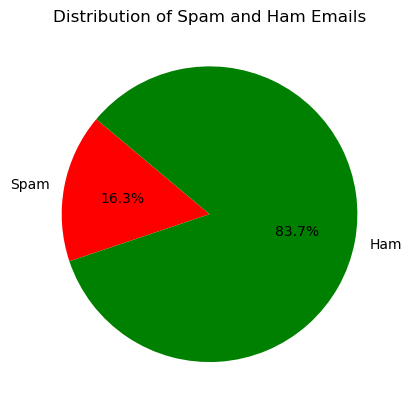

In [25]:
labels = ['Spam', 'Ham']
sizes = [len(data[data['label'] == 1]), len(data[data['label'] == 0])]
colors = ['red', 'green']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Ham Emails')
plt.show()

##### Logistic Regression

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(data['content'], data['label'], test_size=0.1, random_state=225, stratify=data['label'])
model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(solver="lbfgs"))
])
model.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [27]:
y_pred = model.predict(X_test)
print("Accuracy: ", accuracy_score(Y_test, y_pred))
print("Precision: ", precision_score(Y_test, y_pred, average='weighted'))
print("Recall: ", recall_score(Y_test, y_pred, average='weighted'))
print(confusion_matrix(Y_test, y_pred))

Accuracy:  0.9652777777777778
Precision:  0.9666611332447985
Recall:  0.9652777777777778
[[241   0]
 [ 10  37]]


#### Naive Bayes

In [28]:
model_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])   
model_1.fit(X_train, Y_train)
y_pred = model_1.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, y_pred):.2f}")
print(f"Precision: {precision_score(Y_test, y_pred, average='weighted'):.2f}")
print(f"Recall: {recall_score(Y_test, y_pred, average='weighted'):.2f}")
print(confusion_matrix(Y_test, y_pred))

Accuracy: 0.91
Precision: 0.92
Recall: 0.91
[[241   0]
 [ 27  20]]
